In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vamshi2203a52127","key":"7f6f18972d6e93029e69a686f7597d8c"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Replace with your dataset identifier
!kaggle datasets download -d ismailnasri20/driver-drowsiness-dataset-ddd
!unzip -q driver-drowsiness-dataset-ddd.zip -d data/


Dataset URL: https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd
License(s): unknown


In [3]:
import os, shutil
from sklearn.model_selection import train_test_split

base_dir = '/content/data/Driver Drowsiness Dataset (DDD)'
drowsy_dir = os.path.join(base_dir, 'Drowsy')
non_drowsy_dir = os.path.join(base_dir, 'Non Drowsy')

output_base = '/content/organized_data'
train_dir = os.path.join(output_base, 'train')
val_dir = os.path.join(output_base, 'val')
test_dir = os.path.join(output_base, 'test')

for split in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(split, 'Drowsy'), exist_ok=True)
    os.makedirs(os.path.join(split, 'Non Drowsy'), exist_ok=True)

def split_and_copy(class_dir, label):
    files = os.listdir(class_dir)
    train_files, testval_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(testval_files, test_size=0.5, random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(class_dir, f), os.path.join(train_dir, label, f))
    for f in val_files:
        shutil.copy(os.path.join(class_dir, f), os.path.join(val_dir, label, f))
    for f in test_files:
        shutil.copy(os.path.join(class_dir, f), os.path.join(test_dir, label, f))

split_and_copy(drowsy_dir, 'Drowsy')
split_and_copy(non_drowsy_dir, 'Non Drowsy')


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

# --- Paths
img_size = 224
batch_size = 32
epochs = 10

base_dir = '/content/organized_data'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# --- ImageDataGenerators (with augmentation for training to prevent overfitting)
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

# --- Data Loaders
train_data = train_gen.flow_from_directory(train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='binary')
val_data = val_gen.flow_from_directory(val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='binary')
test_data = test_gen.flow_from_directory(test_dir, target_size=(img_size, img_size), batch_size=1, class_mode='binary', shuffle=False)



# Example usage (replace with a real image path):
# predict_image('/content/data/Driver Drowsiness Dataset (DDD)/Drowsy/sample.jpg')


Found 29254 images belonging to 2 classes.
Found 6269 images belonging to 2 classes.
Found 6270 images belonging to 2 classes.


In [6]:

# --- CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size,img_size,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# --- Early Stopping Callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# --- Model Training
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    callbacks=[early_stop]
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 415s 449ms/step - accuracy: 0.7292 - loss: 0.5159 - val_accuracy: 0.9927 - val_loss: 0.0242
Epoch 2/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 410s 448ms/step - accuracy: 0.9745 - loss: 0.0751 - val_accuracy: 0.9931 - val_loss: 0.0188
Epoch 3/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 414s 452ms/step - accuracy: 0.9898 - loss: 0.0304 - val_accuracy: 0.9987 - val_loss: 0.0065
Epoch 4/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 404s 441ms/step - accuracy: 0.9879 - loss: 0.0334 - val_accuracy: 0.9995 - val_loss: 0.0011
Epoch 5/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 404s 441ms/step - accuracy: 0.9948 - loss: 0.0168 - val_accuracy: 0.9989 - val_loss: 0.0046
Epoch 6/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 404s 442ms/step - accuracy: 0.9949 - loss: 0.0183 - val_accuracy: 0.9936 - val_loss: 0.0362
Epoch 7/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 403s 440ms/step - accuracy: 0.9894 - loss: 0.0344 - val_accuracy: 0.9998 - val_loss: 3.3034e-04
Epoch 8/10
915/915 ━━━━━━━━━━━━━━━━━━━━ 403s 440ms/step - accuracy: 0.99

6270/6270 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9985 - loss: 0.0038
Test Accuracy: 0.9992
6270/6270 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3353
           1       1.00      1.00      1.00      2917

    accuracy                           1.00      6270
   macro avg       1.00      1.00      1.00      6270
weighted avg       1.00      1.00      1.00      6270

[[3349    4]
 [   1 2916]]


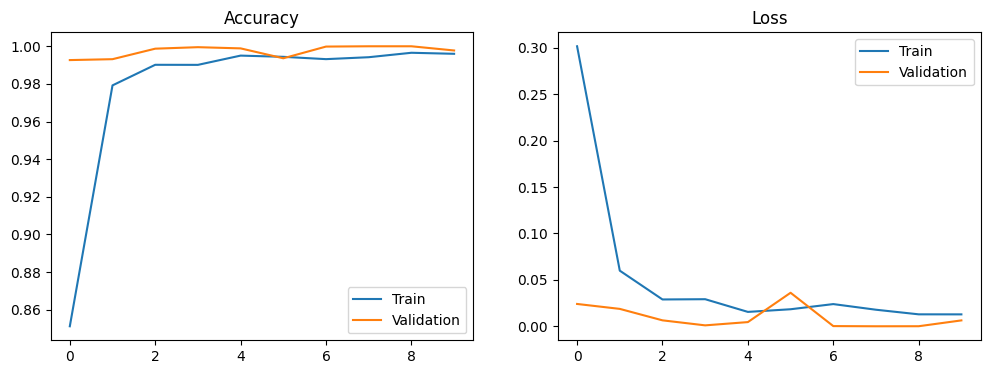

In [7]:
# --- Evaluation
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy:.4f}")

# --- Confusion Matrix + Report
predictions = (model.predict(test_data) > 0.5).astype("int32")
print(classification_report(test_data.classes, predictions))
print(confusion_matrix(test_data.classes, predictions))

# --- Plotting Accuracy & Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.show()


6270/6270 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step
📊 Confusion Matrix (Raw):
[[3349    4]
 [   1 2916]]

📝 Classification Report:
              precision    recall  f1-score   support

  Non-Drowsy       1.00      1.00      1.00      3353
      Drowsy       1.00      1.00      1.00      2917

    accuracy                           1.00      6270
   macro avg       1.00      1.00      1.00      6270
weighted avg       1.00      1.00      1.00      6270



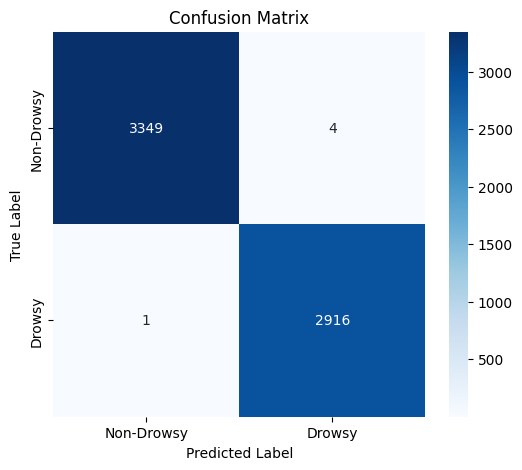

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# --- Get predictions
predictions = (model.predict(test_data) > 0.5).astype("int32")

# --- Confusion Matrix and Classification Report
cm = confusion_matrix(test_data.classes, predictions)
labels = ['Non-Drowsy', 'Drowsy']

print("📊 Confusion Matrix (Raw):")
print(cm)

print("\n📝 Classification Report:")
print(classification_report(test_data.classes, predictions, target_names=labels))

# --- Confusion Matrix Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


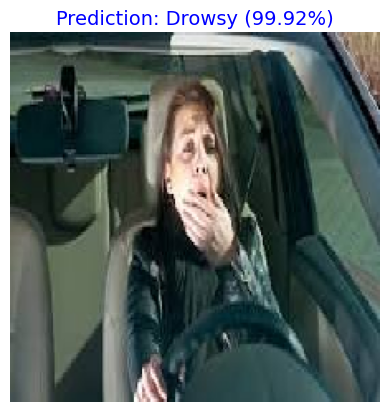

✅ Predicted Class: Drowsy
📈 Confidence: 99.92%


In [27]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np

def predict_image(image_path):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make prediction
    prediction = model.predict(img_array)[0][0]
    confidence = prediction * 100 if prediction > 0.5 else (1 - prediction) * 100
    label = "Drowsy" if prediction <= 0.5 else "Non-Drowsy"

    # Show image with prediction info
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence:.2f}%)", fontsize=14, color='blue')
    plt.show()

    # Also print in console
    print(f"✅ Predicted Class: {label}")
    print(f"📈 Confidence: {confidence:.2f}%")


# Example usage
predict_image('/content/drowsy2.jpeg')